In [3]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from keras.utils import to_categorical
from keras import Sequential
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

2025-12-11 00:08:59.058358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 00:08:59.990086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 00:09:01.977716: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
# ============================================
# CONFIG
# ============================================
TRAIN_DIR = "datasets/train"
TEST_DIR = "datasets/test"
IMG_SIZE = 224

In [5]:
# ============================================
# FEATURE EXTRACTION FUNCTION
# ============================================
def extract_features(folder_path):
    X = []
    y = []
    class_count = {}

    for label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, label)
        if not os.path.isdir(class_folder):
            continue

        # counter kelas
        class_count[label] = 0

        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            hog_feature = hog(gray, orientations=9, pixels_per_cell=(16,16),
                              cells_per_block=(2,2), block_norm="L2-Hys")

            hist = cv2.calcHist([img], [0,1,2], None, [8,8,8], 
                                [0,256,0,256,0,256]).flatten()

            feature_vec = np.hstack([hog_feature, hist])

            X.append(feature_vec)
            y.append(label)

            class_count[label] += 1

    return np.array(X), np.array(y), class_count

In [6]:
# ============================================
# LOAD TRAIN & TEST DATA
# ============================================
print("[INFO] Extracting training features...")
X_train, y_train, train_count = extract_features(TRAIN_DIR)

print("[INFO] Extracting testing features...")
X_test, y_test, test_count = extract_features(TEST_DIR)

print("\n================ Dataset Summary ================")
print(f"Total Training Samples: {len(X_train)}")
for lbl, cnt in train_count.items():
    print(f"   - {lbl}: {cnt}")

print(f"\nTotal Testing Samples: {len(X_test)}")
for lbl, cnt in test_count.items():
    print(f"   - {lbl}: {cnt}")

print("=================================================\n")

[INFO] Extracting training features...


[INFO] Extracting testing features...

================ Dataset Summary ================
Total Training Samples: 1200
   - Medium: 300
   - Green: 300
   - Light: 300
   - Dark: 300

Total Testing Samples: 400
   - Medium: 100
   - Green: 100
   - Light: 100
   - Dark: 100



In [7]:
# ============================================
# FEATURE INSPECTION (Optional)
# ============================================

print("[INFO] Feature Shape:")
print(f" - Training feature shape: {X_train.shape}")
print(f" - Testing feature shape:  {X_test.shape}")

# Jumlah fitur per gambar
print(f"\nTotal features per image: {X_train.shape[1]}")

# Tambahan info HOG vs Histogram (optional)
dummy_img = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
dummy_gray = cv2.cvtColor(dummy_img, cv2.COLOR_BGR2GRAY)

num_hog = len(hog(dummy_gray, orientations=9, pixels_per_cell=(16,16), 
                  cells_per_block=(2,2), block_norm="L2-Hys"))

num_hist = len(cv2.calcHist([dummy_img], [0,1,2], None, [8,8,8], 
                            [0,256,0,256,0,256]).flatten())

print(f"\nFeature Breakdown:")
print(f" - HOG features:  {num_hog}")
print(f" - Color Histogram features: {num_hist}")
print(f" - Total: {num_hog + num_hist}")



[INFO] Feature Shape:
 - Training feature shape: (1200, 6596)
 - Testing feature shape:  (400, 6596)

Total features per image: 6596

Feature Breakdown:
 - HOG features:  6084
 - Color Histogram features: 512
 - Total: 6596


In [8]:
# ============================================
# LABEL ENCODING
# ============================================
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

In [9]:
# ============================================
# FEATURE SCALING (IMPORTANT FOR KNN AND Random Forest)
# ============================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# ============================================
# CONFUSION MATRIX
# ============================================
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=encoder.classes_, 
                yticklabels=encoder.classes_)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [11]:
# ============================================
# MODEL 1 — KNN
# ============================================
print("\n==================== KNN Training ====================")

knn = KNeighborsClassifier(n_neighbors=3, metric="canberra")
knn.fit(X_train_scaled, y_train_enc)

y_pred_knn = knn.predict(X_test_scaled)


==================== KNN Training ====================



[RESULT] KNN Accuracy: 0.835
              precision    recall  f1-score   support

        Dark       0.72      0.87      0.79       100
       Green       0.90      0.99      0.94       100
       Light       0.97      0.74      0.84       100
      Medium       0.80      0.74      0.77       100

    accuracy                           0.83       400
   macro avg       0.85      0.83      0.83       400
weighted avg       0.85      0.83      0.83       400


=== Confusion Matrix: KNN ===


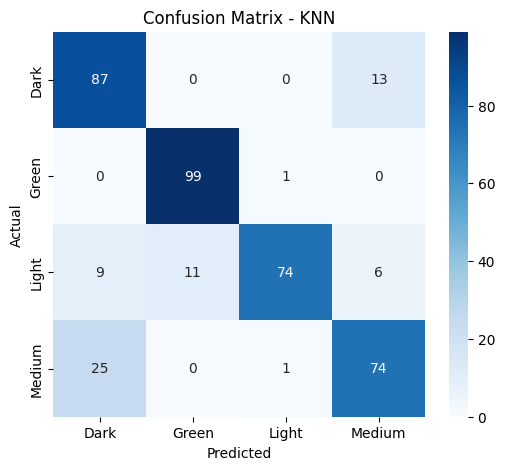

In [12]:
print("\n[RESULT] KNN Accuracy:", accuracy_score(y_test_enc, y_pred_knn))
print(classification_report(y_test_enc, y_pred_knn, target_names=encoder.classes_))
print("\n=== Confusion Matrix: KNN ===")
plot_conf_matrix(y_test_enc, y_pred_knn, "Confusion Matrix - KNN")

In [13]:
# ============================================
# MODEL 2 — Random Forest
# ============================================
print("\n==================== Random Forest Training ====================")

rf = RandomForestClassifier(n_estimators=80)
rf.fit(X_train_scaled, y_train_enc)

y_pred_rf = rf.predict(X_test_scaled)


==================== Random Forest Training ====================



[RESULT] Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00       100
       Green       1.00      1.00      1.00       100
       Light       1.00      1.00      1.00       100
      Medium       1.00      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


=== Confusion Matrix: Random Forest ===


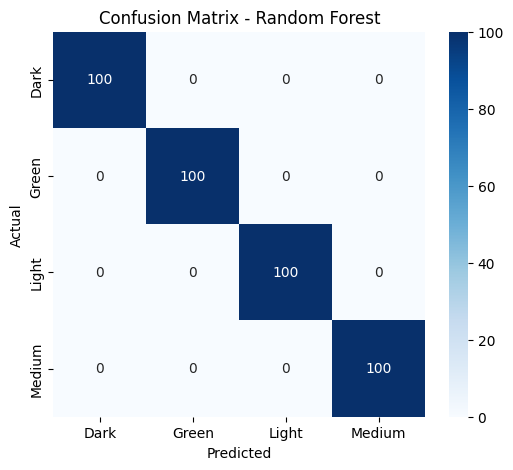

In [14]:
print("\n[RESULT] Random Forest Accuracy:", accuracy_score(y_test_enc, y_pred_rf))
print(classification_report(y_test_enc, y_pred_rf, target_names=encoder.classes_))
print("\n=== Confusion Matrix: Random Forest ===")
plot_conf_matrix(y_test_enc, y_pred_rf, "Confusion Matrix - Random Forest")

In [15]:
# Save Model Result
# Save models
joblib.dump(knn, "knn_model.pkl")
joblib.dump(rf, "random_forest_model.pkl")

# Save scaler & label encoder biar bisa dipakai lagi
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "encoder.pkl")


['encoder.pkl']

In [16]:
# === DATA LOADER FOR CNN ===
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [17]:
# ============================================
# MODEL 3 — CNN + InceptionV3
# ============================================
print("\n==================== CNN Training ====================")

num_classes = len(train_generator.class_indices)

base_model = InceptionV3(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights="imagenet")
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)

output_layer = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
#model.summary()


==================== CNN Training ====================


I0000 00:00:1765386563.502334    1344 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4082 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [18]:
history = model.fit(
    train_generator, 
    validation_data=test_generator,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/20


2025-12-11 00:09:30.620514: I external/local_xla/xla/service/service.cc:163] XLA service 0x76c1380030b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-11 00:09:30.620540: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 SUPER, Compute Capability 7.5
2025-12-11 00:09:30.763529: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-11 00:09:32.158176: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


 1/38 ━━━━━━━━━━━━━━━━━━━━ 7:34 12s/step - accuracy: 0.2188 - loss: 2.3771

I0000 00:00:1765386578.714166    1563 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 589ms/step - accuracy: 0.5917 - loss: 1.0488 - val_accuracy: 0.8950 - val_loss: 0.4113
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.8450 - loss: 0.4378 - val_accuracy: 0.9225 - val_loss: 0.2912
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.8833 - loss: 0.3245 - val_accuracy: 0.9425 - val_loss: 0.2274
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9000 - loss: 0.2986 - val_accuracy: 0.9300 - val_loss: 0.2216
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.9142 - loss: 0.2370 - val_accuracy: 0.9400 - val_loss: 0.1835
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.9300 - loss: 0.2203 - val_accuracy: 0.9475 - val_loss: 0.1686
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9317 - loss: 0.2011 - val_accuracy: 0.9575 - val_loss: 0.1512
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.9258 - loss: 0.1989 - val_accuracy: 0.9550 - v

In [19]:
# === EVALUATION ===
loss, acc = model.evaluate(test_generator)
print(f"\n🔥 Model Accuracy: {acc * 100:.2f}%")
print(f"📉 Model Loss: {loss:.4f}")

 4/13 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9010 - loss: 0.2672

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9700 - loss: 0.0951

🔥 Model Accuracy: 97.00%
📉 Model Loss: 0.0951


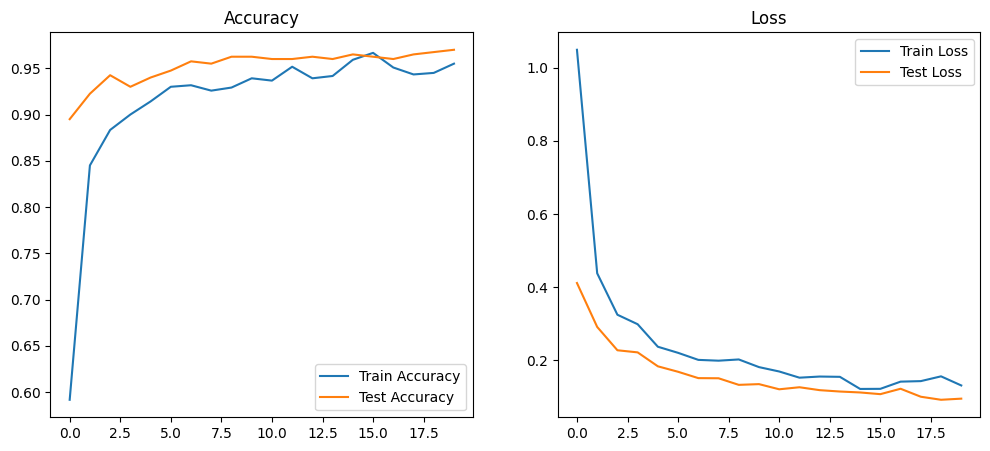

In [20]:
# === VISUALIZE TRAINING ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Test Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.title("Loss")
plt.legend()

plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step
              precision    recall  f1-score   support

        Dark       0.99      0.92      0.95       100
       Green       0.98      1.00      0.99       100
       Light       0.98      0.98      0.98       100
      Medium       0.93      0.98      0.96       100

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



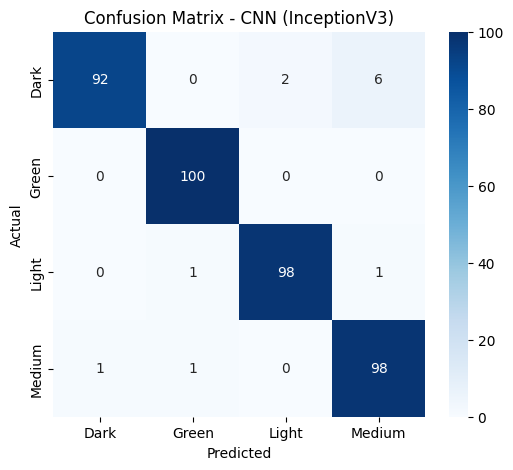

In [21]:
# =============================
#  PREDICT CNN
# =============================

# Ambil label ground truth dari generator
y_true = test_generator.classes  
class_labels = list(test_generator.class_indices.keys())

# Prediksi model (probability → argmax)
y_pred = model.predict(test_generator)
y_pred_class = np.argmax(y_pred, axis=1)

# =============================
#  CONFUSION MATRIX & CLASSIFICATION REPORT
# =============================
print(classification_report(y_true, y_pred_class, target_names=class_labels))
cm = confusion_matrix(y_true, y_pred_class)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - CNN (InceptionV3)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [22]:
# Save Model Result

model.save("inception_model.h5")